# Data Exploration

In [1]:
#Importing necessary libraries

import numpy as np
import statistics as st
import glob
import os
import sys
import io

import zipfile
import tarfile
import gzip
import logging
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Function to load data

def load_data(in_file, max_example=None, relabeling=True):
    

    documents = []
    questions = []
    answers = []
    num_examples = 0
    f = open(in_file, 'r', encoding='utf-8')
    while True:
        line = f.readline()
        if not line:
            break
        question = line.strip().lower()
        answer = f.readline().strip()
        document = f.readline().strip().lower()

        if relabeling:
            q_words = question.split(' ')
            d_words = document.split(' ')
            assert answer in d_words

            entity_dict = {}
            entity_id = 0
            for word in d_words + q_words:
                if (word.startswith('@entity')) and (word not in entity_dict):
                    entity_dict[word] = '@entity' + str(entity_id)
                    entity_id += 1

            q_words = [entity_dict[w] if w in entity_dict else w for w in q_words]
            d_words = [entity_dict[w] if w in entity_dict else w for w in d_words]
            answer = entity_dict[answer]

            question = ' '.join(q_words)
            document = ' '.join(d_words)

        questions.append(question)
        answers.append(answer)
        documents.append(document)
        num_examples += 1

        f.readline()
        if (max_example is not None) and (num_examples >= max_example):
            break
    f.close()
    #logging.info('#Examples: %d' % len(documents))
    print('#Examples: %d' % len(documents))
    return (documents, questions, answers)

In [3]:
#Function to build dictionaries for analysis

def build_dict_1(sentences, max_words=120000):
    """
        Build a dictionary for the words in `sentences`.
        Only the max_words ones are kept and the remaining will be mapped to <UNK>.
    """
    
    Total_wrds = 0
    
    word_count = Counter()
    #doc_wc = Counter()
    #doc_ec = Counter()
    for ix, sent in enumerate(sentences):
        for w in sent.split(' '):
            #doc_ec[ix] += 1
            #doc_wc[ix] += 1
            Total_wrds += 1
            word_count[w] += 1
            
    print("Total no of words = ", Total_wrds)

    ls = word_count.most_common(max_words)
    print('#Words: %d -> %d' % (len(word_count), len(ls)))
    print("The words occuring with highest frequencies \n")
    for key in ls[:20]:
        print(key)
    print('...')
    print("The words occuring with lowest frequencies \n")
    for key in ls[-20:]:
        print(key)

    # leave 0 to UNK
    # leave 1 to delimiter |||
    
    vocab_dict = {w[0]: index for (index, w) in enumerate(ls)}
    
    
    return vocab_dict, Total_wrds

In [4]:
#Function to vectorize the tokenized data for analysis

def vectorize(examples, word_dict, entity_dict):
    """
        Vectorize `examples`.
        in_x1, in_x2: sequences for document and question respecitvely.
        in_y: label
        in_l: whether the entity label occurs in the document.
    
    """
    in_x1 = []
    in_x2 = []
    in_y = []
    in_y_1 = []
    
    max_d = 0
    max_q = 0
    
    
    for idx, (d, q, a) in enumerate(zip(examples[0], examples[1], examples[2])):
        d_words = d.split(' ')
        q_words = q.split(' ')
        assert (a in d_words)
        seq1 = [word_dict[w] if w in word_dict else 0 for w in d_words]
        seq2 = [word_dict[w] if w in word_dict else 0 for w in q_words]
        
        if max_d < len(seq1):
            max_d = len(seq1)
        if max_q < len(seq2):
            max_q = len(seq2)
        
        if (len(seq1) > 0) and (len(seq2) > 0):
            in_x1.append(seq1)
            in_x2.append(seq2)
            in_y.append(entity_dict[a] if a in entity_dict else 0)  #answer entities w.r.t to entity_dict
            in_y_1.append(word_dict[a] if a in word_dict else 0) #answer entities w.r.t to word_dict
            
        if (idx % 10000 == 0):
            print('Vectorization: processed %d / %d' % (idx, len(examples[0])))


    

    return in_x1, in_x2, in_y, in_y_1, max_d, max_q

In [5]:
#Function to generate details for the analysis of statistics of documents

def docs_stats(doc_s, ans, exps):
    
    #index -> document number
    doc_lengths = []
    no_entities = []
    ans_1st_loc = []
    count_ans = []
    ans_locs = []
    
    for i, an in enumerate(ans):
        
        
        doc_lengths.append(len(doc_s[i]))
        
        ans_1st_loc.append(doc_s[i].index(an))
        
        loc_wrds =[]
        
        for j, wrd in enumerate(doc_s[i]):
            
            if wrd == an:
                loc_wrds.append(j)
        
        entities_c = 0
                         
        for ws in exps[i].split(' '):
            
            if ws.startswith('@entity'):
                entities_c += 1
        
        
        
        no_entities.append(entities_c)
        
        count_ans.append(len(loc_wrds))
        
        ans_locs.append(loc_wrds)
        
        
        
    return doc_lengths, no_entities, ans_1st_loc, count_ans, ans_locs

In [6]:
#Function to generate details for the analysis of statistics of questions

def ques_stats(que_s, exps):
    
    #index -> question number
    que_lengths = []
    no_entities = []
    
    for i in range(len(que_s)):
        
        que_lengths.append(len(que_s[i]))
        
        entities_c = 0
        
        for ws in exps[i].split(' '):
            if ws.startswith('@entity'):
                entities_c += 1
                
        
        no_entities.append(entities_c)
        
        
        
    return que_lengths, no_entities

In [7]:
#Function to generate the range

def max_min(paras):    
    
    
    max_length = 0
    min_length = 10000000000

    for i in range (len(paras)):
    

        if (max_length < paras[i]):
            max_length = paras[i]
            
        
        if (min_length > paras[i]):
            min_length = paras[i]
            
   
    return max_length, min_length

### Download the CNN Dataset:

Our CNN dataset's default directory is `./data/cnn/`. There are three files: `train.txt`, `test.txt`, and `dev.txt`.
The following function checks whether the CNN dataset is in the default directory or not. If not, then it will download the dataset from [here](http://cs.stanford.edu/~danqi/data/cnn.tar.gz) and extract it to the default directory.

In [ ]:
def check_CNN_dataset_exists(path_data='./data/'):
    flag_train_data = os.path.isfile(path_data + 'cnn/train.txt')  
    flag_test_data = os.path.isfile(path_data + 'cnn/test.txt') 
    flag_dev_data = os.path.isfile(path_data + 'cnn/dev.txt') 
    if flag_train_data==False or flag_test_data==False or flag_dev_data==False:
        print('CNN dataset missing - downloading...')
        if not os.path.exists(path_data):
            os.makedirs(path_data)
        url = "http://cs.stanford.edu/~danqi/data/cnn.tar.gz"
        os.system('wget http://cs.stanford.edu/~danqi/data/cnn.tar.gz -P ./data/')
        tar = tarfile.open('./data/cnn.tar.gz', "r:gz")
        tar.extractall('./data/')
        tar.close()
    else:
        print("CNN dataset is already there!")
        

check_CNN_dataset_exists()

In [8]:
#Loading all data


fin_train = "./data/cnn/train.txt" #path of the training data text file.
fin_dev = "./data/cnn/dev.txt"     #path of the validation data text file.
fin_test = "./data/cnn/test.txt"   #path of the testing data text file.

train_exps = load_data(fin_train, relabeling=True)
dev_exps = load_data(fin_dev, relabeling=True)
test_exps = load_data(fin_test, relabeling=True)

#Examples: 380298
#Examples: 3924
#Examples: 3198


# Analysis of training data

In [9]:
#generating of word dictionary and entity dictionary to analyse training data

word_dict_1, total_1 = build_dict_1(train_exps[0] + train_exps[1])
entity_markers = list(set([w for w in word_dict_1.keys() if w.startswith('@entity')] + train_exps[2]))
entity_dict = {w: index for (index, w) in enumerate(entity_markers)}

Total no of words =  294458658
#Words: 118432 -> 118432
The words occuring with highest frequencies 

('the', 15383021)
(',', 13757778)
('.', 11782121)
('to', 7208903)
('"', 6967510)
('of', 6176653)
('and', 6157410)
('a', 6108894)
('in', 5784281)
("'s", 3323130)
('that', 2955242)
('for', 2377320)
('is', 2304007)
('@entity1', 2218582)
('-', 2217557)
('on', 2126318)
('it', 2050882)
('said', 2043159)
('was', 1997226)
('@entity2', 1956108)
...
The words occuring with lowest frequencies 

('seseparateampaigns', 1)
('yorkshire', 1)
('issa', 1)
('unseats', 1)
('catalo', 1)
('625k', 1)
('fretboard', 1)
('ex-illinois', 1)
('harding', 1)
('slavers', 1)
('reapplies', 1)
('ponting', 1)
('post-fdr', 1)
('theratens', 1)
('ex-mississippi', 1)
('slingers', 1)
('multi-planet', 1)
('johnstons', 1)
('shir', 1)
('khurma', 1)


In [10]:
#Vectorization of training data for analysis

trn_x1, trn_x2, trn_y, trn_y_1, max_d, max_q = vectorize(train_exps, word_dict_1, entity_dict)

Vectorization: processed 0 / 380298
Vectorization: processed 10000 / 380298
Vectorization: processed 20000 / 380298
Vectorization: processed 30000 / 380298
Vectorization: processed 40000 / 380298
Vectorization: processed 50000 / 380298
Vectorization: processed 60000 / 380298
Vectorization: processed 70000 / 380298
Vectorization: processed 80000 / 380298
Vectorization: processed 90000 / 380298
Vectorization: processed 100000 / 380298
Vectorization: processed 110000 / 380298
Vectorization: processed 120000 / 380298
Vectorization: processed 130000 / 380298
Vectorization: processed 140000 / 380298
Vectorization: processed 150000 / 380298
Vectorization: processed 160000 / 380298
Vectorization: processed 170000 / 380298
Vectorization: processed 180000 / 380298
Vectorization: processed 190000 / 380298
Vectorization: processed 200000 / 380298
Vectorization: processed 210000 / 380298
Vectorization: processed 220000 / 380298
Vectorization: processed 230000 / 380298
Vectorization: processed 24000

In [11]:
#Generating details to analyse statistics of training documents

document_lengths, doc_entity_numbers, answer_1st_loc, no_answers, answer_locs = docs_stats(trn_x1, trn_y_1, train_exps[0])



In [12]:
#Generating details to analyse statistics of training questions

ques_lengths, ques_entity_numbers = ques_stats(trn_x2, train_exps[1])



In [13]:
#Basic details of training corpus

print("Total number of tokens in training corpus with repititions = ", total_1,"\n")

print("Total number of token in training corpus without repititions = ", len(word_dict_1),"\n")

print("Total number of entities in training corpus = ",len(entity_dict),"\n")

Total number of tokens in training corpus with repititions =  294458658 

Total number of token in training corpus without repititions =  118432 

Total number of entities in training corpus =  527 



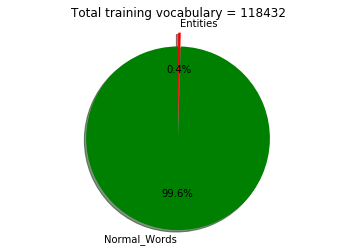

In [33]:
# Pie Chart to represent the number of total entities as a percentage of total vocabulary

labels = 'Normal_Words', 'Entities'
sizes = [(len(word_dict_1)-len(entity_dict)), len(entity_dict)]
explode = (0, 0.15)  # only "explode" the 2nd slice (i.e. 'Entities')
colors = ['green','red']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(('Total training vocabulary = ' + str(len(word_dict_1))))

plt.show()

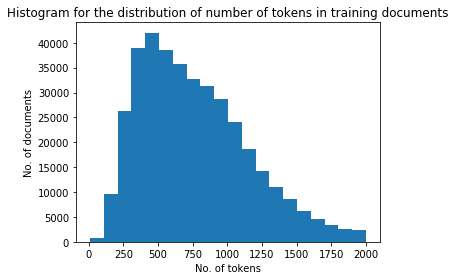

In [21]:
# Generating histogram for the distribution of number of tokens in training documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(document_lengths), n_bins, histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of number of tokens in training documents')

fig.tight_layout()
plt.show()

In [22]:
#Generating statistics for the distribution of tokens in training documents

mode = st.mode(document_lengths)
median = st.median(document_lengths)
mean = st.mean(document_lengths)

max_v, min_v = max_min(document_lengths)


print("Statistics for the distribution of number of tokens in training documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of tokens in training documents 

The range = [ 8  ,  2000 ]
The mode =  474
The median = 700.0
The mean = 761.8135172943323


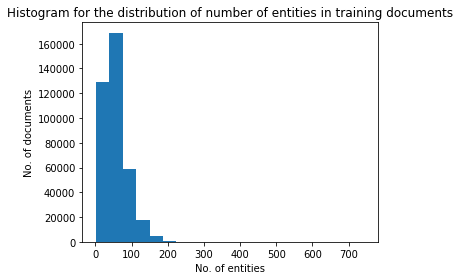

In [23]:
#Generating histogram for the distribution of number of entities in training documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(doc_entity_numbers), n_bins, histtype='bar')
ax.set_xlabel('No. of entities')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of number of entities in training documents')

fig.tight_layout()
plt.show()

In [24]:
#Generating statistics for the distribution of number of entities in training documents

mode = st.mode(doc_entity_numbers)
median = st.median(doc_entity_numbers)
mean = st.mean(doc_entity_numbers)

max_v, min_v = max_min(doc_entity_numbers)


print("Statistics for the distribution of number of entities in training documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of entities in training documents 

The range = [ 1  ,  745 ]
The mode =  34
The median = 49.0
The mean = 56.09781276788203


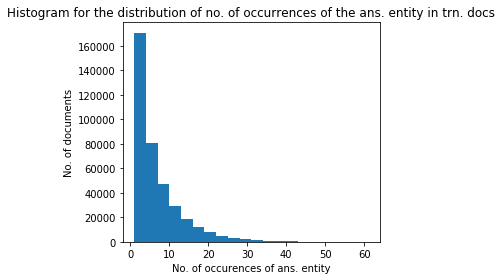

In [25]:
#Generating histogram for the distribution of number of occurrences of the answer entity in training documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(no_answers), n_bins, histtype='bar')
ax.set_xlabel('No. of occurences of ans. entity')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of no. of occurrences of the ans. entity in trn. docs')

fig.tight_layout()
plt.show()

In [26]:
#Generating statistics for the distribution of number of occurrences of the answer entity in training documents

mode = st.mode(no_answers)
median = st.median(no_answers)
mean = st.mean(no_answers)

max_v, min_v = max_min(no_answers)


print("Statistics for the distribution of number of occurrences of the answer entity in training documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of occurrences of the answer entity in training documents 

The range = [ 1  ,  61 ]
The mode =  1
The median = 4.0
The mean = 6.277198407564594


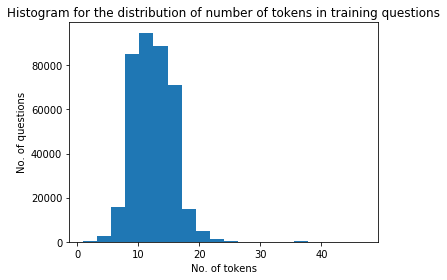

In [27]:
#Generating histogram for the distribution of number of tokens in training questions

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(ques_lengths), n_bins, histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of questions')
ax.set_title('Histogram for the distribution of number of tokens in training questions')

fig.tight_layout()
plt.show()

In [28]:
#Generating statistics for the distribution of number of tokens in training questions

mode = st.mode(ques_lengths)
median = st.median(ques_lengths)
mean = st.mean(ques_lengths)

max_v, min_v = max_min(ques_lengths)


print("Statistics for the distribution of number of tokens in training questions \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of tokens in training questions 

The range = [ 1  ,  47 ]
The mode =  12
The median = 12.0
The mean = 12.470486302846714


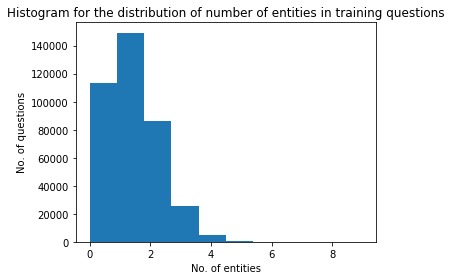

In [34]:
#Generating histogram for the distribution of number of entities in training questions

fig, ax = plt.subplots()

n_bins = 10

ax.hist(np.array(ques_entity_numbers), n_bins, histtype='bar')
ax.set_xlabel('No. of entities')
ax.set_ylabel('No. of questions')
ax.set_title('Histogram for the distribution of number of entities in training questions')

fig.tight_layout()
plt.show()

In [35]:
#Generating statistics for the distribution of number of entities in training questions

mode = st.mode(ques_entity_numbers)
median = st.median(ques_entity_numbers)
mean = st.mean(ques_entity_numbers)

max_v, min_v = max_min(ques_entity_numbers)


print("Statistics for the distribution of number of entities in training questions \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of entities in training questions 

The range = [ 0  ,  9 ]
The mode =  1
The median = 1.0
The mean = 1.1156987415132344


# Analysis of validation data

In [36]:
#generating of word dictionary and entity dictionary to analyse validation data

word_dict_2, total_2 = build_dict_1(dev_exps[0] + dev_exps[1])
entity_markers_2 = list(set([w for w in word_dict_2.keys() if w.startswith('@entity')] + dev_exps[2]))
entity_dict_2 = {w: index for (index, w) in enumerate(entity_markers_2)}

Total no of words =  3045165
#Words: 24204 -> 24204
The words occuring with highest frequencies 

('the', 156088)
(',', 144355)
('.', 124209)
('"', 77821)
('to', 74478)
('a', 65551)
('of', 64074)
('and', 63741)
('in', 60281)
("'s", 34998)
('that', 31805)
('is', 24460)
('@entity1', 24273)
('for', 23302)
('was', 23232)
('he', 22355)
('on', 22152)
('it', 21543)
('@entity2', 21316)
('said', 19440)
...
The words occuring with lowest frequencies 

('decompose', 1)
('surfaces', 1)
('indulged', 1)
('observances', 1)
('naga', 1)
('illustrator', 1)
('no.1', 1)
('fulton', 1)
('stomping', 1)
('fmr', 1)
('executes', 1)
('exporters', 1)
('stats', 1)
('exits', 1)
('judaism', 1)
('de-emphasized', 1)
('prioritizing', 1)
('pours', 1)
('scud', 1)
('a-level', 1)


In [37]:
#Vectorization of validation data for analysis

val_x1, val_x2, val_y, val_y_1, max_d, max_q = vectorize(dev_exps, word_dict_2, entity_dict_2)


Vectorization: processed 0 / 3924


In [38]:
#Generating details to analyse statistics of validation documents

document_lengths, doc_entity_numbers, answer_1st_loc, no_answers, answer_locs = docs_stats(val_x1, val_y_1, dev_exps[0])


In [39]:

#Generating details to analyse statistics of validation questions

ques_lengths, ques_entity_numbers = ques_stats(val_x2, dev_exps[1])



In [40]:
#Basic details of validation corpus

print("Total number of tokens in validation corpus with repititions = ", total_2, "\n")

print("Total number of token in validation corpus without repititions = ", len(word_dict_2),"\n")

print("Total number of entities in validation corpus = ",len(entity_dict_2),"\n")

Total number of tokens in validation corpus with repititions =  3045165 

Total number of token in validation corpus without repititions =  24204 

Total number of entities in validation corpus =  187 



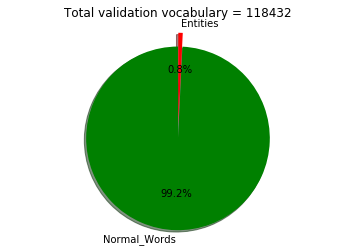

In [41]:
# Pie Chart to represent the number of total entities as a percentage of total vocabulary

labels = 'Normal_Words', 'Entities'
sizes = [(len(word_dict_2)-len(entity_dict_2)), len(entity_dict_2)]
explode = (0, 0.15)  # only "explode" the 2nd slice (i.e. 'Entities')
colors = ['green','red']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(('Total validation vocabulary = ' + str(len(word_dict_1))))

plt.show()

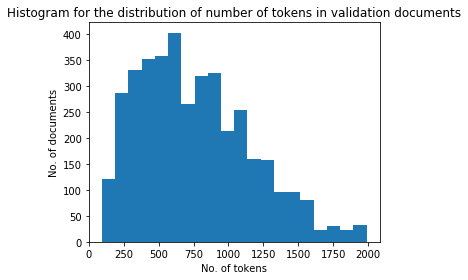

In [42]:
# Generating histogram for the distribution of number of tokens in validation documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(document_lengths), n_bins, histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of number of tokens in validation documents')

fig.tight_layout()
plt.show()

In [43]:
#Generating statistics for the distribution of tokens in validation documents

mode = st.mode(document_lengths)
median = st.median(document_lengths)
mean = st.mean(document_lengths)

max_v, min_v = max_min(document_lengths)


print("Statistics for the distribution of number of tokens in validation documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of tokens in validation documents 

The range = [ 94  ,  1989 ]
The mode =  1102
The median = 710.0
The mean = 762.7461773700306


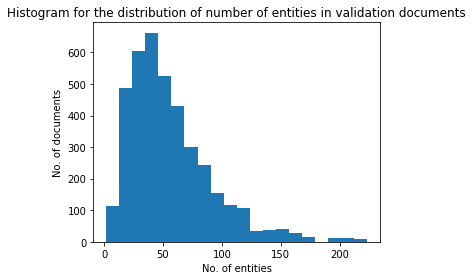

In [44]:
#Generating histogram for the distribution of number of entities in validation documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(doc_entity_numbers), n_bins, histtype='bar')
ax.set_xlabel('No. of entities')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of number of entities in validation documents')

fig.tight_layout()
plt.show()

In [45]:
#Generating statistics for the distribution of number of entities in validation documents

mode = st.mode(doc_entity_numbers)
median = st.median(doc_entity_numbers)
mean = st.mean(doc_entity_numbers)

max_v, min_v = max_min(doc_entity_numbers)


print("Statistics for the distribution of number of entities in validation documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of entities in validation documents 

The range = [ 2  ,  223 ]
The mode =  40
The median = 48.0
The mean = 56.57517838939857


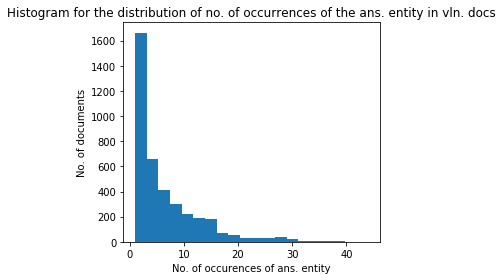

In [46]:
#Generating histogram for the distribution of number of occurrences of the answer entity in validation documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(no_answers), n_bins, histtype='bar')
ax.set_xlabel('No. of occurences of ans. entity')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of no. of occurrences of the ans. entity in vln. docs')

fig.tight_layout()
plt.show()

In [47]:
#Generating statistics for the distribution of number of occurrences of the answer entity in validation documents

mode = st.mode(no_answers)
median = st.median(no_answers)
mean = st.mean(no_answers)

max_v, min_v = max_min(no_answers)


print("Statistics for the distribution of number of occurrences of the answer entity in validation documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of occurrences of the answer entity in validation documents 

The range = [ 1  ,  44 ]
The mode =  1
The median = 4.0
The mean = 6.480632008154944


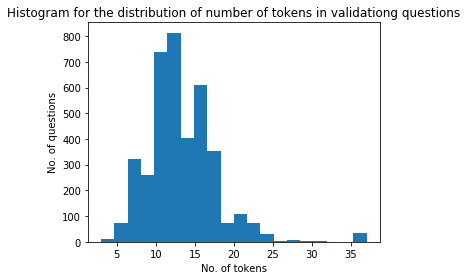

In [48]:
#Generating histogram for the distribution of number of tokens in validation questions

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(ques_lengths), n_bins, histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of questions')
ax.set_title('Histogram for the distribution of number of tokens in validationg questions')

fig.tight_layout()
plt.show()

In [49]:
#Generating statistics for the distribution of number of tokens in validation questions

mode = st.mode(ques_lengths)
median = st.median(ques_lengths)
mean = st.mean(ques_lengths)

max_v, min_v = max_min(ques_lengths)


print("Statistics for the distribution of number of tokens in validation questions \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of tokens in validation questions 

The range = [ 3  ,  37 ]
The mode =  12
The median = 13.0
The mean = 13.289755351681958


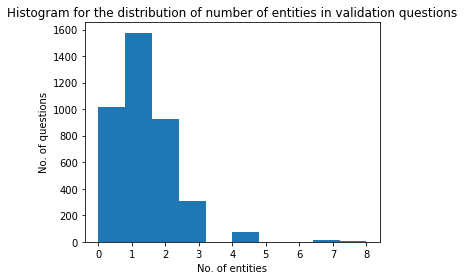

In [50]:
#Generating histogram for the distribution of number of entities in validation questions

fig, ax = plt.subplots()

n_bins = 10

ax.hist(np.array(ques_entity_numbers), n_bins, histtype='bar')
ax.set_xlabel('No. of entities')
ax.set_ylabel('No. of questions')
ax.set_title('Histogram for the distribution of number of entities in validation questions')

fig.tight_layout()
plt.show()

In [51]:
#Generating statistics for the distribution of number of entities in validation questions

mode = st.mode(ques_entity_numbers)
median = st.median(ques_entity_numbers)
mean = st.mean(ques_entity_numbers)

max_v, min_v = max_min(ques_entity_numbers)


print("Statistics for the distribution of number of entities in validation questions \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of entities in validation questions 

The range = [ 0  ,  8 ]
The mode =  1
The median = 1.0
The mean = 1.2313965341488278


# Analysis of testing data

In [52]:
#generating of word dictionary and entity dictionary to analyse testing data

word_dict_3, total_3 = build_dict_1(test_exps[0] + test_exps[1])
entity_markers_3 = list(set([w for w in word_dict_3.keys() if w.startswith('@entity')] + test_exps[2]))
entity_dict_3 = {w: index for (index, w) in enumerate(entity_markers_3)}

Total no of words =  2335076
#Words: 23145 -> 23145
The words occuring with highest frequencies 

('the', 121825)
(',', 115094)
('.', 98196)
('"', 58600)
('to', 56728)
('and', 50264)
('of', 49159)
('a', 48850)
('in', 45228)
("'s", 25555)
('that', 24427)
('@entity1', 19273)
('is', 18912)
('for', 17636)
('on', 17372)
('was', 17284)
('it', 16621)
('@entity2', 15945)
('he', 15416)
('said', 15388)
...
The words occuring with lowest frequencies 

('ag', 1)
('referral', 1)
('takeovers', 1)
('abated', 1)
('bogged', 1)
('passable', 1)
('sayings', 1)
('ensnared', 1)
('strewn', 1)
('archival', 1)
('smearing', 1)
('censor', 1)
('overturn', 1)
('heighten', 1)
('insulator', 1)
('fostered', 1)
('surrenders', 1)
('multistate', 1)
('airlifting', 1)
('racy', 1)


In [53]:
#Vectorization of testing data for analysis

tst_x1, tst_x2, tst_y, tst_y_1, max_d, max_q = vectorize(test_exps, word_dict_3, entity_dict_3)

Vectorization: processed 0 / 3198


In [54]:
#Generating details to analyse statistics of testing documents

document_lengths1, doc_entity_numbers, answer_1st_loc, no_answers, answer_locs = docs_stats(tst_x1, tst_y_1, test_exps[0])


In [55]:
#Generating details to analyse statistics of testing questions

ques_lengths, ques_entity_numbers = ques_stats(tst_x2, test_exps[1])



In [56]:
#Basic details of testing corpus

print("Total number of tokens in testing corpus with repititions = ", total_3, "\n")

print("Total number of token in testing corpus without repititions = ", len(word_dict_3),"\n")

print("Total number of entities in testing corpus = ",len(entity_dict_3),"\n")

Total number of tokens in testing corpus with repititions =  2335076 

Total number of token in testing corpus without repititions =  23145 

Total number of entities in testing corpus =  396 



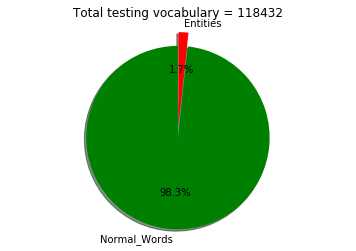

In [68]:
# Pie Chart to represent the number of total entities as a percentage of total vocabulary

labels = 'Normal_Words', 'Entities'
sizes = [(len(word_dict_3)-len(entity_dict_3)), len(entity_dict_3)]
explode = (0, 0.15)  # only "explode" the 2nd slice (i.e. 'Entities')
colors = ['green','red']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(('Total testing vocabulary = ' + str(len(word_dict_1))))

plt.show()

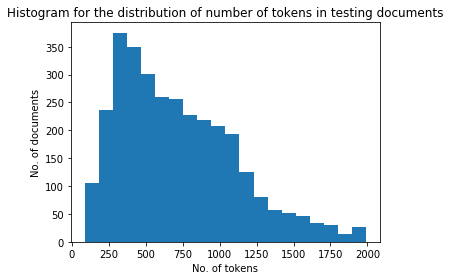

In [58]:
# Generating histogram for the distribution of number of tokens in testing documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(document_lengths1), n_bins, histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of number of tokens in testing documents')

fig.tight_layout()
plt.show()

In [59]:
#Generating statistics for the distribution of tokens in testing documents

mode = st.mode(document_lengths1)
median = st.median(document_lengths1)
mean = st.mean(document_lengths1)

max_v, min_v = max_min(document_lengths1)


print("Statistics for the distribution of number of tokens in testing documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of tokens in testing documents 

The range = [ 89  ,  1989 ]
The mode =  1095
The median = 652.0
The mean = 716.442464040025


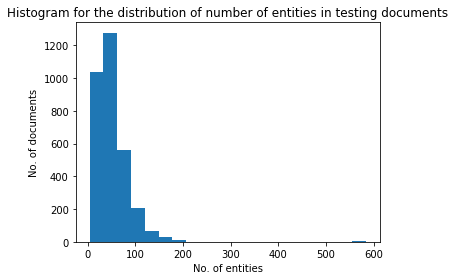

In [60]:
#Generating histogram for the distribution of number of entities in testing documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(doc_entity_numbers), n_bins, histtype='bar')
ax.set_xlabel('No. of entities')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of number of entities in testing documents')

fig.tight_layout()
plt.show()

In [61]:
#Generating statistics for the distribution of number of entities in testing documents

mode = st.mode(doc_entity_numbers)
median = st.median(doc_entity_numbers)
mean = st.mean(doc_entity_numbers)

max_v, min_v = max_min(doc_entity_numbers)


print("Statistics for the distribution of number of entities in testing documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of entities in testing documents 

The range = [ 4  ,  584 ]
The mode =  31
The median = 43.0
The mean = 51.515322076297686


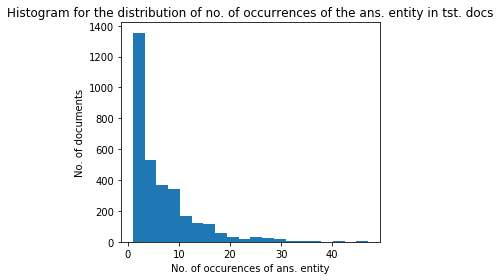

In [62]:
#Generating histogram for the distribution of number of occurrences of the answer entity in testing documents

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(no_answers), n_bins, histtype='bar')
ax.set_xlabel('No. of occurences of ans. entity')
ax.set_ylabel('No. of documents')
ax.set_title('Histogram for the distribution of no. of occurrences of the ans. entity in tst. docs')

fig.tight_layout()
plt.show()

In [63]:
#Generating statistics for the distribution of number of occurrences of the answer entity in testing documents

mode = st.mode(no_answers)
median = st.median(no_answers)
mean = st.mean(no_answers)

max_v, min_v = max_min(no_answers)


print("Statistics for the distribution of number of occurrences of the answer entity in testing documents \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of occurrences of the answer entity in testing documents 

The range = [ 1  ,  47 ]
The mode =  1
The median = 4.0
The mean = 6.363352095059412


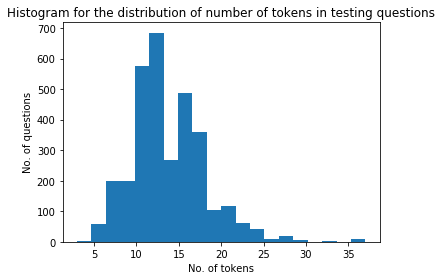

In [64]:
#Generating histogram for the distribution of number of tokens in testing questions

fig, ax = plt.subplots()

n_bins = 20

ax.hist(np.array(ques_lengths), n_bins, histtype='bar')
ax.set_xlabel('No. of tokens')
ax.set_ylabel('No. of questions')
ax.set_title('Histogram for the distribution of number of tokens in testing questions')

fig.tight_layout()
plt.show()

In [65]:
#Generating statistics for the distribution of number of tokens in testing questions

mode = st.mode(ques_lengths)
median = st.median(ques_lengths)
mean = st.mean(ques_lengths)

max_v, min_v = max_min(ques_lengths)


print("Statistics for the distribution of number of tokens in testing questions \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of tokens in testing questions 

The range = [ 3  ,  37 ]
The mode =  13
The median = 13.0
The mean = 13.72514071294559


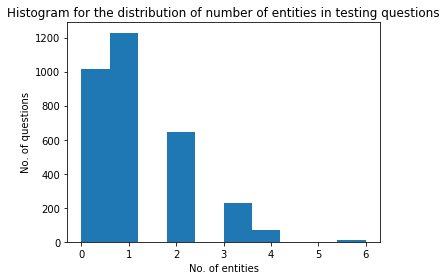

In [66]:
#Generating histogram for the distribution of number of entities in testing questions

fig, ax = plt.subplots()

n_bins = 10

ax.hist(np.array(ques_entity_numbers), n_bins, histtype='bar')
ax.set_xlabel('No. of entities')
ax.set_ylabel('No. of questions')
ax.set_title('Histogram for the distribution of number of entities in testing questions')

fig.tight_layout()
plt.show()

In [67]:
#Generating statistics for the distribution of number of entities in testing questions

mode = st.mode(ques_entity_numbers)
median = st.median(ques_entity_numbers)
mean = st.mean(ques_entity_numbers)

max_v, min_v = max_min(ques_entity_numbers)


print("Statistics for the distribution of number of entities in testing questions \n")

print("The range = [",min_v," , ",max_v,"]")
print("The mode = ",mode)
print("The median =",median)
print("The mean =", mean)

Statistics for the distribution of number of entities in testing questions 

The range = [ 0  ,  6 ]
The mode =  1
The median = 1.0
The mean = 1.1106941838649156
